In [8]:
!pip install pyspark

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import col,explode,array,lit
from pyspark.sql.functions import when
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import confusion_matrix
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import LinearSVC

from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [10]:
import pyspark as ps
spark = ps.sql.SparkSession.builder.master('local').appName('Classification').getOrCreate()
from pyspark.sql import SparkSession
# Read the csv file
file= "./indian-liver-patient-records/indian_liver_patient.csv"
liver_data = spark.read.csv(file, header=True, inferSchema=True)
liver_data.show(5)

+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+
|Age|Gender|Total_Bilirubin|Direct_Bilirubin|Alkaline_Phosphotase|Alamine_Aminotransferase|Aspartate_Aminotransferase|Total_Protiens|Albumin|Albumin_and_Globulin_Ratio|Dataset|
+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+
| 65|Female|            0.7|             0.1|                 187|                      16|                        18|           6.8|    3.3|                       0.9|      1|
| 62|  Male|           10.9|             5.5|                 699|                      64|                       100|           7.5|    3.2|                      0.74|      1|
| 62|  Male|            7.3|             4.1|                 490|                      60|                        

In [11]:
spark

In [12]:
liver_data.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Total_Bilirubin: double (nullable = true)
 |-- Direct_Bilirubin: double (nullable = true)
 |-- Alkaline_Phosphotase: integer (nullable = true)
 |-- Alamine_Aminotransferase: integer (nullable = true)
 |-- Aspartate_Aminotransferase: integer (nullable = true)
 |-- Total_Protiens: double (nullable = true)
 |-- Albumin: double (nullable = true)
 |-- Albumin_and_Globulin_Ratio: double (nullable = true)
 |-- Dataset: integer (nullable = true)



In [13]:
num_features = [t[0] for t in liver_data.dtypes if t[1] in ['int', 'double'] and t[0] not in ['Age', 'Dataset']]
liver_data.select(num_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Total_Bilirubin,583,3.298799313893652,6.209521726180151,0.4,75.0
Direct_Bilirubin,583,1.4861063464837074,2.808497617658965,0.1,19.7
Alkaline_Phosphotase,583,290.57632933104634,242.93798917934402,63,2110
Alamine_Aminotransferase,583,80.71355060034305,182.6203560342026,10,2000
Aspartate_Aminotransferase,583,109.91080617495712,288.9185290517341,10,4929
Total_Protiens,583,6.483190394511151,1.0854514840234648,2.7,9.6
Albumin,583,3.14185248713551,0.795518805964026,0.9,5.5
Albumin_and_Globulin_Ratio,579,0.9470639032815201,0.31959210767237056,0.3,2.8


In [14]:
#Calculate the missing values
missing_values_count = liver_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in liver_data.columns])

# Show the count of missing values
missing_values_count.show()

+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+
|Age|Gender|Total_Bilirubin|Direct_Bilirubin|Alkaline_Phosphotase|Alamine_Aminotransferase|Aspartate_Aminotransferase|Total_Protiens|Albumin|Albumin_and_Globulin_Ratio|Dataset|
+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+
|  0|     0|              0|               0|                   0|                       0|                         0|             0|      0|                         4|      0|
+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+



In [15]:
# Load the CSV file into a DataFrame
file = "./indian-liver-patient-records/indian_liver_patient.csv"
df = pd.read_csv(file)

# Fill missing values 
fill_value = 0.9470639032815201  # mean value
df['Albumin_and_Globulin_Ratio'].fillna(fill_value, inplace=True)

#Storing the updated column in a file
dir_path = os.path.dirname(file)

out_file_path = os.path.join(dir_path, "indian_liver_patient_modified.csv")

os.makedirs(os.path.dirname(out_file_path), exist_ok=True)

# Save the DataFrame to the CSV file
df.to_csv(out_file_path, index=False)

In [16]:
#print the missing values after imputation

df = pd.read_csv(out_file_path)
null_counts = df.isnull().sum()
print(null_counts)

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64


In [17]:
liver_data.groupBy('Dataset').count().show()  #1---> disease 2---> no disease

+-------+-----+
|Dataset|count|
+-------+-----+
|      1|  416|
|      2|  167|
+-------+-----+



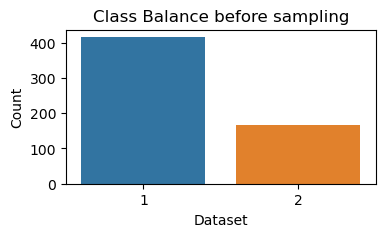

In [18]:
#Checking class balance of target column "Dataset"
balance = liver_data.groupBy("Dataset").count()
# Convert into Pandas DataFrame for plotting
balance_pd = balance.toPandas()
# Plot class balance using Seaborn
plt.figure(figsize=(4, 2))
sns.barplot(data=balance_pd, x="Dataset", y="count")
plt.title("Class Balance before sampling")
plt.xlabel("Dataset")
plt.ylabel("Count")
plt.show()

In [19]:
#oversampling
disease_df=liver_data.filter(col("Dataset")==1)
no_disease_df=liver_data.filter(col("Dataset")==2)
ratio = int(disease_df.count()/no_disease_df.count())
print("ratio: {}".format(ratio))
m = range(ratio)# duplicate the minority rows
oversampled_df = no_disease_df.withColumn("dummy", explode(array([lit(x) for x in m]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
liver_data = disease_df.unionAll(oversampled_df)
liver_data.show(10)

ratio: 2
+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+
|Age|Gender|Total_Bilirubin|Direct_Bilirubin|Alkaline_Phosphotase|Alamine_Aminotransferase|Aspartate_Aminotransferase|Total_Protiens|Albumin|Albumin_and_Globulin_Ratio|Dataset|
+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+
| 65|Female|            0.7|             0.1|                 187|                      16|                        18|           6.8|    3.3|                       0.9|      1|
| 62|  Male|           10.9|             5.5|                 699|                      64|                       100|           7.5|    3.2|                      0.74|      1|
| 62|  Male|            7.3|             4.1|                 490|                      60|               

In [20]:
#Count after oversampling
liver_data.groupBy('Dataset').count().show()

+-------+-----+
|Dataset|count|
+-------+-----+
|      1|  416|
|      2|  334|
+-------+-----+



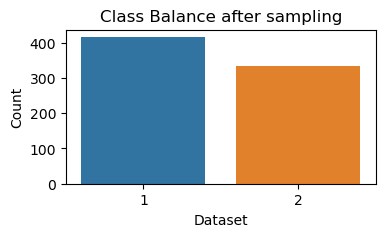

In [81]:
#Plot after after class balancing
target = liver_data.groupBy("Dataset").count()

# Convert class balance to Pandas DataFrame for plotting
target_pd = target.toPandas()

# Plot class balance using Seaborn
plt.figure(figsize=(4, 2))
sns.barplot(data=target_pd, x="Dataset", y="count")
plt.title("Class Balance after sampling")
plt.xlabel("Dataset")
plt.ylabel("Count")
plt.show()

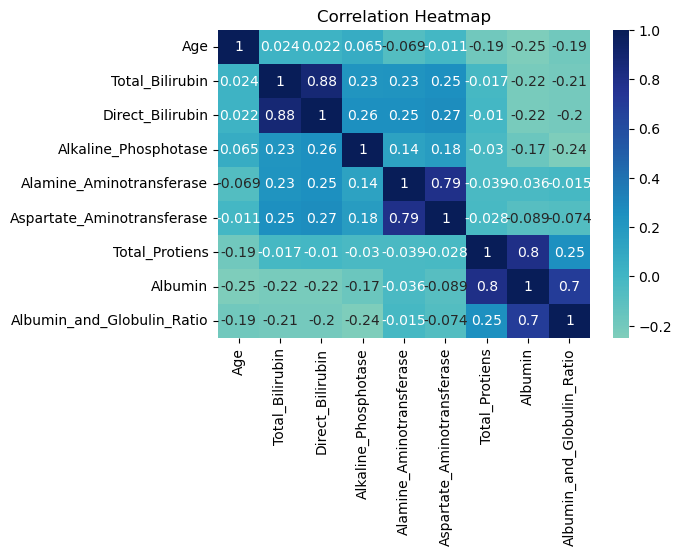

In [58]:
#Correlation matrix
# List all numeric columns except string and target columns
exclude_columns = ['Dataset', 'Gender']  
num_columns = [col for col in liver_data.columns if col not in exclude_columns]

# Select only the numeric columns of interest
liver_data_numeric = liver_data.select(*num_columns)

# Assemble features into a vector column, handling null values
assembler = VectorAssembler(inputCols=num_columns, outputCol="features", handleInvalid="skip")
assembled_data = assembler.transform(liver_data)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(assembled_data, "features").collect()[0][0]

# Convert correlation matrix to a Pandas DataFrame
correlation_df = pd.DataFrame(correlation_matrix.toArray(), columns=num_columns, index=num_columns)

# Plot the correlation heatmap using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_df, annot=True, cmap='YlGnBu', center=0)
plt.title("Correlation Heatmap")
plt.show()


In [59]:
# Replace the values in the "Dataset" column
liver_data = liver_data.withColumn("Dataset", when(liver_data["Dataset"] == 2, 0).otherwise(liver_data["Dataset"]))

liver_data.groupBy('Dataset').count().show()

+-------+-----+
|Dataset|count|
+-------+-----+
|      1|  416|
|      0|  334|
+-------+-----+



In [60]:
#String indexing,Onehot encoding and Vector assembler

# Replace the values in the "Dataset" column
liver1_data = liver_data.withColumn("Dataset", when(liver_data["Dataset"] == 2, 0).otherwise(liver_data["Dataset"]))

# Numeric columns for standardization
numeric_columns = ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 
                   'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens',
                   'Albumin', 'Albumin_and_Globulin_Ratio']

# Check if the "numeric_features" column already exists
if "numeric_features" in liver1_data.columns:
    liver1_data = liver1_data.drop("numeric_features")

# Assemble the numeric features into a single vector column
num_assembler = VectorAssembler(inputCols=numeric_columns, outputCol="numeric_features")
num_assembler.setHandleInvalid("keep")
liver2_data = num_assembler.transform(liver1_data)

# Convert 'Gender' column into numerical indices
gender_indexer = StringIndexer(inputCol="Gender", outputCol="Gender_Index")

# Apply one-hot encoding to the indexed gender column
gender_encoder = OneHotEncoder(inputCol="Gender_Index", outputCol="Gender_OneHot")

# Assemble the features for model input
input_columns = ["numeric_features", "Gender_OneHot"]
feature_assembler = VectorAssembler(inputCols=input_columns, outputCol="features")

# Create a pipeline for gender indexing and one-hot encoding
pipeline = Pipeline(stages=[gender_indexer, gender_encoder, feature_assembler])

# Fit and transform the data using the pipeline
processed_data = pipeline.fit(liver2_data).transform(liver2_data)

# Show the assembled features
processed_data.select("features", "Gender", "Gender_Index","Gender_OneHot").show(truncate=False)



+-------------------------------------------------+------+------------+-------------+
|features                                         |Gender|Gender_Index|Gender_OneHot|
+-------------------------------------------------+------+------------+-------------+
|[65.0,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.9,0.0]   |Female|1.0         |(1,[],[])    |
|[62.0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1.0]|Male  |0.0         |(1,[0],[1.0])|
|[62.0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1.0]  |Male  |0.0         |(1,[0],[1.0])|
|[58.0,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.0,1.0]   |Male  |0.0         |(1,[0],[1.0])|
|[72.0,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.4,1.0]   |Male  |0.0         |(1,[0],[1.0])|
|[46.0,1.8,0.7,208.0,19.0,14.0,7.6,4.4,1.3,1.0]   |Male  |0.0         |(1,[0],[1.0])|
|[26.0,0.9,0.2,154.0,16.0,12.0,7.0,3.5,1.0,0.0]   |Female|1.0         |(1,[],[])    |
|[29.0,0.9,0.3,202.0,14.0,11.0,6.7,3.6,1.1,0.0]   |Female|1.0         |(1,[],[])    |
|[55.0,0.7,0.2,290.0,53.0,58.0,6.8,3.4,1.0,1.0]   |Mal

In [61]:
#standard scaling

# Assemble the features for model input
input_columns = ["Gender_OneHot"]
feature_assembler = VectorAssembler(inputCols=input_columns, outputCol="raw_features", handleInvalid="keep")

# Create a pipeline for gender indexing and one-hot encoding
preprocessing_pipeline = Pipeline(stages=[gender_indexer, gender_encoder, feature_assembler])

# Fit and transform the data using the preprocessed pipeline
processed_data = preprocessing_pipeline.fit(liver1_data).transform(liver1_data)

# Separate pipeline for scaling the numeric features
numeric_assembler = VectorAssembler(inputCols=numeric_columns, outputCol="numeric_features", handleInvalid="keep")
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features", withStd=True, withMean=True)

scaling_pipeline = Pipeline(stages=[numeric_assembler, scaler])

# Fit and transform the data using the scaling pipeline
scaled_data = scaling_pipeline.fit(processed_data).transform(processed_data)

# Assemble the features for final model input
final_input_columns = ["raw_features", "scaled_numeric_features"]
final_feature_assembler = VectorAssembler(inputCols=final_input_columns, outputCol="features")

final_pipeline = Pipeline(stages=[final_feature_assembler])

# Fit and transform the data using the final pipeline
final_processed_data = final_pipeline.fit(scaled_data).transform(scaled_data)

# Show the assembled features
final_processed_data.select("features", "scaled_numeric_features", "Gender", "Gender_Index", "Gender_OneHot").show(truncate=False)



+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+------------+-------------+
|features                                                                                                                                                                     |scaled_numeric_features                                                                                                                                                  |Gender|Gender_Index|Gender_OneHot|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------

In [62]:
final_processed_data.show(20)

+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+------------+-------------+------------+--------------------+-----------------------+--------------------+
|Age|Gender|Total_Bilirubin|Direct_Bilirubin|Alkaline_Phosphotase|Alamine_Aminotransferase|Aspartate_Aminotransferase|Total_Protiens|Albumin|Albumin_and_Globulin_Ratio|Dataset|Gender_Index|Gender_OneHot|raw_features|    numeric_features|scaled_numeric_features|            features|
+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+------------+-------------+------------+--------------------+-----------------------+--------------------+
| 65|Female|            0.7|             0.1|                 187|                      16|                        18|           6.8|    3.3|          

In [63]:
final_data=final_processed_data.drop('Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 
                   'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens',
                   'Albumin', 'Albumin_and_Globulin_Ratio','numeric_features','Gender_index','Gender_OneHot','Gender','raw_features','scaled_numeric_features')
final_data.show(5)

+-------+--------------------+
|Dataset|            features|
+-------+--------------------+
|      1|[0.0,1.2804928684...|
|      1|[1.0,1.0978667938...|
|      1|[1.0,1.0978667938...|
|      1|[1.0,0.8543653609...|
|      1|[1.0,1.7066203760...|
+-------+--------------------+
only showing top 5 rows



In [64]:
final_data.select("Dataset").distinct().show()

+-------+
|Dataset|
+-------+
|      1|
|      0|
+-------+



In [65]:
# Split data into training and test datasets
trainDataset, testDataset = final_data.randomSplit([0.7, 0.3], seed=123)

Decision tree

In [39]:
# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(labelCol="Dataset", featuresCol="features")

# Define a grid of hyperparameters to search through
param_grid = ParamGridBuilder() \
    .addGrid(dt_classifier.maxDepth, [5, 10, 15]) \
    .addGrid(dt_classifier.maxBins, [16, 32, 64]) \
    .build()

# Creating a CrossValidator with the Decision Tree classifier
crossval = CrossValidator(estimator=dt_classifier,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="accuracy"),
                          numFolds=5) 

# Perform cross-validation and choose the best set of parameters
cv_model = crossval.fit(final_data) 

best_model = cv_model.bestModel

# Evaluate the best model on test data
test_pred = best_model.transform(testDataset) 
evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(test_pred)
print("DT_Accuracy :", accuracy)

# Show both the predicted values and the actual values
test_pred.select("prediction", "Dataset")

# printing the evaluation metrices
evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="weightedPrecision")
weighted_precision = evaluator.evaluate(test_pred)
print("Weighted Precision:", weighted_precision)

evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="weightedRecall")
weighted_recall = evaluator.evaluate(test_pred)
print("Weighted Recall:", weighted_recall)

evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(test_pred)
print("F1 Score:", f1_score)

# get predictions and actual labels
results = test_pred.select(['prediction', 'Dataset']).collect()
predictions = [int(row.prediction) for row in results]
labels = [int(row.Dataset) for row in results]

# Create a confusion matrix
confusion = confusion_matrix(labels, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

# Add BinaryClassificationEvaluator for ROC AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="Dataset", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binary_evaluator.evaluate(test_pred)
print("ROC AUC:", roc_auc)

DT_Accuracy : 0.9724770642201835
Weighted Precision: 0.9732823231563643
Weighted Recall: 0.9724770642201834
F1 Score: 0.9725479022498158
Confusion Matrix:
[[ 91   1]
 [  5 121]]
ROC AUC: 0.9554002760524498


Random Forest

In [66]:
# Create a RandomForest classifier with hyper parameter tuning
rf_classifier = RandomForestClassifier(labelCol="Dataset", featuresCol="features", numTrees=10)
# Define a grid of hyperparameters
param_grid = ParamGridBuilder() \
    .addGrid(rf_classifier.maxDepth, [5, 10, 15]) \
    .addGrid(rf_classifier.minInstancesPerNode, [1, 5, 10]) \
    .build()
# Create a CrossValidator with the RandomForest classifier
crossval = CrossValidator(estimator=rf_classifier,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="accuracy"),
                          numFolds=7) 
# Perform cross-validation and choose the best set of parameters
cv_model = crossval.fit(final_data) 
# Get the best model from cross-validation
best_model = cv_model.bestModel
# Evaluate the best model on test data
test_pred = best_model.transform(testDataset)
evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(test_pred)
print("RF_Accuracy:", accuracy)
# printing the evaluation metrices
evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="weightedPrecision")
weighted_precision = evaluator.evaluate(test_pred)
print("Weighted Precision:", weighted_precision)
evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="weightedRecall")
weighted_recall = evaluator.evaluate(test_pred)
print("Weighted Recall:", weighted_recall)
evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(test_pred)
print("F1 Score:", f1_score)
# get predictions and actual labels
results = test_pred.select(['prediction', 'Dataset']).collect()
predictions = [int(row.prediction) for row in results]
labels = [int(row.Dataset) for row in results]
# Create a confusion matrix
confusion = confusion_matrix(labels, predictions)
# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

# Add BinaryClassificationEvaluator for ROC AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="Dataset", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binary_evaluator.evaluate(test_pred)
print("ROC AUC:", roc_auc)


RF_Accuracy: 0.9908256880733946
Weighted Precision: 0.9910208861994925
Weighted Recall: 0.9908256880733946
F1 Score: 0.990838315083358
Confusion Matrix:
[[ 92   0]
 [  2 124]]
ROC AUC: 0.9998274672187715


GBT

In [41]:

# GBTClassifier with tuning
gbt_classifier = GBTClassifier(labelCol="Dataset", featuresCol="features")

# Define a parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(gbt_classifier.maxDepth, [5, 10, 15]) \
    .addGrid(gbt_classifier.maxBins, [16, 32, 64]) \
    .addGrid(gbt_classifier.maxIter, [10, 20, 30]) \
    .build()

# Create a TrainValidationSplit
evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="accuracy")
split = TrainValidationSplit(estimator=gbt_classifier, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.7)

# Fit the TrainValidationSplit to the training data
split_model = split.fit(trainDataset)

# Make predictions on the test data using the best model from TrainValidationSplit
best_model = split_model.bestModel
test_pred = best_model.transform(testDataset)

# Evaluate the model
accuracy = evaluator.evaluate(test_pred)
print("GBT_accuracy:", accuracy)

# Printing the evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="weightedPrecision")
weighted_precision = evaluator.evaluate(test_pred)
print("Weighted Precision:", weighted_precision)

evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="weightedRecall")
weighted_recall = evaluator.evaluate(test_pred)
print("Weighted Recall:", weighted_recall)

evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(test_pred)
print("F1 Score:", f1_score)

# Get predictions and actual labels
results = test_pred.select(['prediction', 'Dataset']).collect()
predictions = [int(row.prediction) for row in results]
labels = [int(row.Dataset) for row in results]

# Create a confusion matrix
confusion = confusion_matrix(labels, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

# Add BinaryClassificationEvaluator for ROC AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="Dataset", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binary_evaluator.evaluate(test_pred)
print("ROC AUC:", roc_auc)


GBT_accuracy: 0.7752293577981652
Weighted Precision: 0.8043918197998488
Weighted Recall: 0.7752293577981652
F1 Score: 0.7759155142039686
Confusion Matrix:
[[82 10]
 [39 87]]
ROC AUC: 0.8559351276742587


SVM

In [42]:

# Create an SVM classifier
svm_classifier = LinearSVC(labelCol="Dataset", featuresCol="features")

# Create a ParamGrid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(svm_classifier.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(svm_classifier.maxIter, [5, 10, 20]) \
    .build()

# Create a CrossValidator with evaluator and param grid
evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="accuracy")
cross_validator = CrossValidator(estimator=svm_classifier, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=9)

# Fit the CrossValidator to the training data
cv_model = cross_validator.fit(trainDataset)

# Get the best model from cross validation
best_model = cv_model.bestModel

# Make predictions on the test data using the best model
test_pred = best_model.transform(testDataset)

# Evaluate the model
accuracy = evaluator.evaluate(test_pred)
print("SVM_Accuracy:", accuracy)

# Print the evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="weightedPrecision")
weighted_precision = evaluator.evaluate(test_pred)
print("Weighted Precision:", weighted_precision)

evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="weightedRecall")
weighted_recall = evaluator.evaluate(test_pred)
print("Weighted Recall:", weighted_recall)

evaluator = MulticlassClassificationEvaluator(labelCol="Dataset", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(test_pred)
print("F1 Score:", f1_score)

# Get predictions and actual labels
results = test_pred.select(['prediction', 'Dataset']).collect()
predictions = [int(row.prediction) for row in results]
labels = [int(row.Dataset) for row in results]

# Create a confusion matrix
confusion = confusion_matrix(labels, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

# Add BinaryClassificationEvaluator for ROC AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="Dataset", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binary_evaluator.evaluate(test_pred)
print("ROC AUC:", roc_auc)

# Stop the Spark session
spark.stop()


SVM_Accuracy: 0.42201834862385323
Weighted Precision: 0.1780994865752041
Weighted Recall: 0.42201834862385323
F1 Score: 0.2504883101509322
Confusion Matrix:
[[ 92   0]
 [126   0]]
ROC AUC: 0.5
